## Code for performing evaluation with ViFi-CLIP on custom datasets

### Please set the corresponding values in the cell below. Afterwards, just run the cells for inference with ViFi-CLIP model

In [1]:
import pathlib
# Class label csv path
labels_csv_path = '../datasets/kinetics_400_labels.csv'
# Datset folder
dataset_root_path = pathlib.Path('../datasets')

In [2]:
### Set values here ###
config = 'configs/zero_shot/train/k400/16_16_vifi_clip.yaml'
output_folder_name = "outputs"
pretrained_model_path = "ckpts/vifi_clip_10_epochs_k400_full_finetuned.pth"

### Import libraries 

In [3]:
import torch
import torch.nn as nn
from utils.config import get_config
from utils.logger import create_logger
import time
import numpy as np
from utils.config import get_config
from trainers import vificlip
from datasets.pipeline import *

### Setting up configuration, no need to change anything.

In [4]:
# Step 1:
# Configuration class 
class parse_option():
    def __init__(self):
        self.config = config
        self.output =  output_folder_name   # Name of output folder to store logs and save weights
        self.resume = pretrained_model_path
        # No need to change below args.
        self.only_test = True
        self.opts = None
        self.batch_size = None
        self.pretrained = None
        self.accumulation_steps = None
        self.local_rank = 0
args = parse_option()
config = get_config(args)
# logger
logger = create_logger(output_dir=args.output, name=f"{config.MODEL.ARCH}")
logger.info(f"working dir: {config.OUTPUT}")

=> merge config from configs/zero_shot/train/k400/16_16_vifi_clip.yaml
[2024-04-01 18:16:31 ViT-B/16](588939814.py 19): INFO working dir: outputs


### Read Class Labels

In [5]:
import csv

label2id = {}
id2label = {}
with open(labels_csv_path, mode='r') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)

    for row in csv_reader:
        class_id, class_name = row
        label2id[class_name] = class_id
        id2label[class_id] = class_name

class_labels = list(label2id.keys())

print(f"{len(class_labels)} Unique classes: {class_labels}.")

400 Unique classes: ['abseiling', 'air drumming', 'answering questions', 'applauding', 'applying cream', 'archery', 'arm wrestling', 'arranging flowers', 'assembling computer', 'auctioning', 'baby waking up', 'baking cookies', 'balloon blowing', 'bandaging', 'barbequing', 'bartending', 'beatboxing', 'bee keeping', 'belly dancing', 'bench pressing', 'bending back', 'bending metal', 'biking through snow', 'blasting sand', 'blowing glass', 'blowing leaves', 'blowing nose', 'blowing out candles', 'bobsledding', 'bookbinding', 'bouncing on trampoline', 'bowling', 'braiding hair', 'breading or breadcrumbing', 'breakdancing', 'brush painting', 'brushing hair', 'brushing teeth', 'building cabinet', 'building shed', 'bungee jumping', 'busking', 'canoeing or kayaking', 'capoeira', 'carrying baby', 'cartwheeling', 'carving pumpkin', 'catching fish', 'catching or throwing baseball', 'catching or throwing frisbee', 'catching or throwing softball', 'celebrating', 'changing oil', 'changing wheel', 'c

### Loading ViFi-CLIP and its pretrained weights

In [6]:
# Step 2:
# Create the ViFi-CLIP models and load pretrained weights
model = vificlip.returnCLIP(config,
                            logger=logger,
                            class_names=class_labels,)
model = model.float().cuda()  # changing to cuda here


[2024-04-01 18:16:35 ViT-B/16](vificlip.py 204): INFO Loading CLIP (backbone: ViT-B/16)
[2024-04-01 18:16:36 ViT-B/16](vificlip.py 207): INFO Building ViFi-CLIP CLIP
[2024-04-01 18:16:36 ViT-B/16](vificlip.py 224): INFO Turning on gradients for COMPLETE ViFi-CLIP model
[2024-04-01 18:16:36 ViT-B/16](vificlip.py 247): INFO Parameters to be updated: {'image_encoder.transformer.resblocks.8.ln_2.bias', 'image_encoder.transformer.resblocks.8.mlp.c_proj.weight', 'text_encoder.transformer.resblocks.8.mlp.c_proj.bias', 'image_encoder.transformer.resblocks.4.ln_2.bias', 'text_encoder.transformer.resblocks.4.mlp.c_proj.weight', 'text_encoder.transformer.resblocks.6.mlp.c_proj.weight', 'image_encoder.transformer.resblocks.10.mlp.c_proj.bias', 'text_encoder.positional_embedding', 'text_encoder.transformer.resblocks.2.ln_1.bias', 'image_encoder.transformer.resblocks.2.ln_2.weight', 'text_encoder.transformer.resblocks.6.ln_1.bias', 'image_encoder.transformer.resblocks.5.attn.out_proj.weight', 'text_

In [8]:
logger.info(f"==============> Resuming form {config.MODEL.RESUME}....................")
checkpoint = torch.load(config.MODEL.RESUME, map_location='cpu')
load_state_dict = checkpoint['model']
# now remove the unwanted keys:
if "module.prompt_learner.token_prefix" in load_state_dict:
    del load_state_dict["module.prompt_learner.token_prefix"]

if "module.prompt_learner.token_suffix" in load_state_dict:
    del load_state_dict["module.prompt_learner.token_suffix"]

if "module.prompt_learner.complete_text_embeddings" in load_state_dict:
    del load_state_dict["module.prompt_learner.complete_text_embeddings"]
# create new OrderedDict that does not contain `module.`
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in load_state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

[2024-04-01 18:16:39 ViT-B/16](2665388570.py 1): INFO ==============> Resuming form ckpts/vifi_clip_10_epochs_k400_full_finetuned.pth....................


In [9]:
# load params
msg = model.load_state_dict(new_state_dict, strict=False)
logger.info(f"resume model: {msg}")

[2024-04-01 18:16:40 ViT-B/16](3852643250.py 3): INFO resume model: _IncompatibleKeys(missing_keys=['prompt_learner.complete_text_embeddings'], unexpected_keys=[])


### Preprocessing input video 

In [10]:
# Step 3: 
# Preprocessing for video
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_bgr=False)
scale_resize = int(256 / 224 * config.DATA.INPUT_SIZE)
val_pipeline = [
    dict(type='DecordInit'),
    dict(type='SampleFrames', clip_len=1, frame_interval=1, num_clips=config.DATA.NUM_FRAMES, test_mode=True),
    dict(type='DecordDecode'),
    dict(type='Resize', scale=(-1, scale_resize)),
    dict(type='CenterCrop', crop_size=config.DATA.INPUT_SIZE),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='FormatShape', input_format='NCHW'),
    dict(type='Collect', keys=['imgs'], meta_keys=[]),
    dict(type='ToTensor', keys=['imgs'])
]
if config.TEST.NUM_CROP == 3:
    val_pipeline[3] = dict(type='Resize', scale=(-1, config.DATA.INPUT_SIZE))
    val_pipeline[4] = dict(type='ThreeCrop', crop_size=config.DATA.INPUT_SIZE)
if config.TEST.NUM_CLIP > 1:
    val_pipeline[1] = dict(type='SampleFrames', clip_len=1, frame_interval=1, num_clips=config.DATA.NUM_FRAMES, multiview=config.TEST.NUM_CLIP)
pipeline = Compose(val_pipeline)

### Construct dataset

In [12]:
train_paths = list(dataset_root_path.glob("train/*/*.mp4"))
test_paths = list(dataset_root_path.glob("test/*/*.mp4"))


def construct_dataset(file_paths):
    dataset = []
    for video_path in file_paths:
        label = str(video_path).split("\\")[-2]
        dataset.append({'filename': video_path, 'tar': False, 'modality': 'RGB', 'start_index': 0, 'label': label2id[label]})
    return dataset

train_dataset = construct_dataset(train_paths)
print('train_dataset', len(train_dataset), train_dataset[0])
test_dataset = construct_dataset(test_paths)
print('test_dataset', len(test_dataset), test_dataset[0])

train_dataset 50 {'filename': WindowsPath('../datasets/train/crying/9q8mf6GUiiE_000009_000019.mp4'), 'tar': False, 'modality': 'RGB', 'start_index': 0, 'label': '79'}
test_dataset 41 {'filename': WindowsPath('../datasets/test/crying/at-nYO45bnQ_000009_000019.mp4'), 'tar': False, 'modality': 'RGB', 'start_index': 0, 'label': '79'}


### ViFi-CLIP inference with given video

In [21]:
from tqdm import tqdm

def inference(dataset):
    acc1_count = 0
    total_preds = []
    total_labels = []
    total_filename = []
    for i, dict_file in tqdm(enumerate(dataset), total=len(dataset)):
        video = pipeline(dict_file)
        video_tensor = video['imgs'].unsqueeze(0).cuda().float()
        label = int(dict_file['label'])
        # Inference through ViFi-CLIP
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                logits, _, _, _ = model(video_tensor)
        pred_index = logits.argmax(-1).item()

        total_preds.append(pred_index)
        total_labels.append(label)
        total_filename.append(dict_file['filename'])

        # top1 acc
        if pred_index == label: acc1_count += 1
        acc1 = acc1_count / (i+1)

        
    print(f"Top-1 accuracy: {acc1:.3%}, correct: {int(acc1_count)}/{i+1}")

    return total_filename, total_preds, total_labels
    

In [22]:
train_filename, train_preds, train_labels = inference(train_dataset)

test_filename, test_preds, test_labels = inference(test_dataset)

100%|██████████| 50/50 [00:14<00:00,  3.57it/s]


Top-1 accuracy: 92.000%, correct: 46/50


100%|██████████| 41/41 [00:11<00:00,  3.46it/s]

Top-1 accuracy: 58.537%, correct: 24/41


In [23]:
print(len(train_filename), train_filename[0])
print(len(train_preds), train_preds[0])
print(len(train_labels), train_labels[0])

50 ..\datasets\train\crying\9q8mf6GUiiE_000009_000019.mp4
50 79
50 79


# Eval Plots

## t-SNE

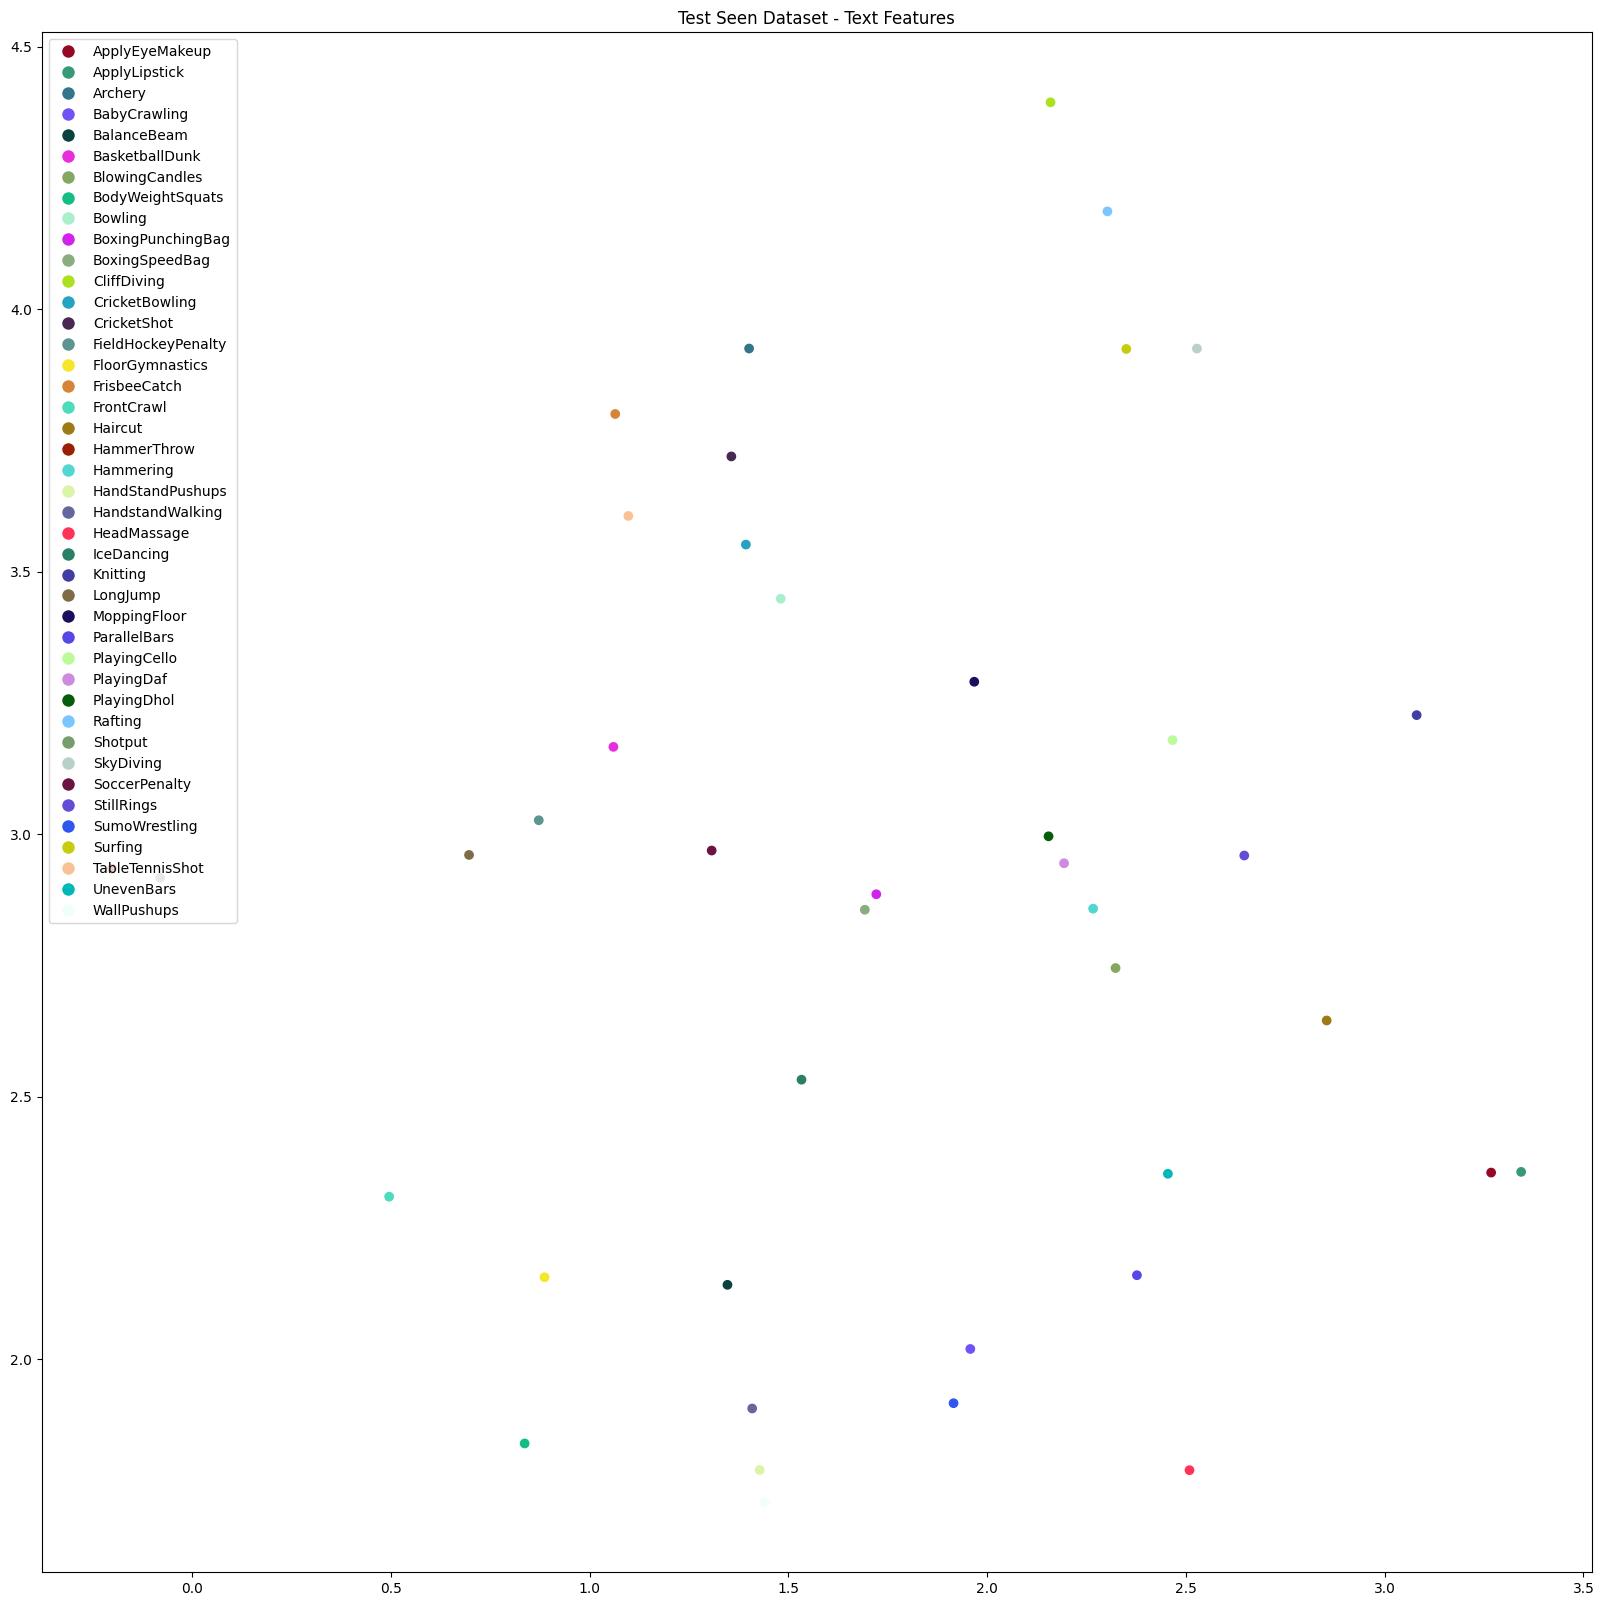

In [48]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D


# added text features
def tsne(total_labels, total_features, total_text_feats, classes, title):
    # tsne color
    r, g, b = np.linspace(0, 1, 51), np.linspace(0, 1, 51), np.linspace(0, 1, 51)
    np.random.seed(0)
    np.random.shuffle(r)
    np.random.shuffle(g)
    np.random.shuffle(b)
    r = r.reshape((-1, 1))
    g = g.reshape((-1, 1))
    b = b.reshape((-1, 1))
    class_colors = np.concatenate((r, g, b), axis=1)
    # colors = class_colors[total_labels]
    colors = class_colors[np.unique(total_labels)]

    # compute 2d tsne
    tsne = TSNE(n_components=2, perplexity=30)
    # X_2d = tsne.fit_transform(total_features)

    total_text_feats = total_text_feats[np.unique(total_labels)]
    X_text_2d = tsne.fit_transform(total_text_feats)

    # plot
    plt.figure(figsize=(20, 20))
    # scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=colors)

    text_scatter = plt.scatter(X_text_2d[:, 0], X_text_2d[:, 1], marker='o', c=colors)

    # legend
    unique_labels = np.unique(total_labels)
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=classes[i], markersize=10,
                              markerfacecolor=class_colors[i]) for i in unique_labels]
    plt.title(title)
    plt.legend(handles=legend_elements, loc='upper left')

    plt.show()

    return

tsne(total_labels, total_img_feats, total_text_feats, class_names, title='Test Seen Dataset - Text Features')


## Confusion Matrix

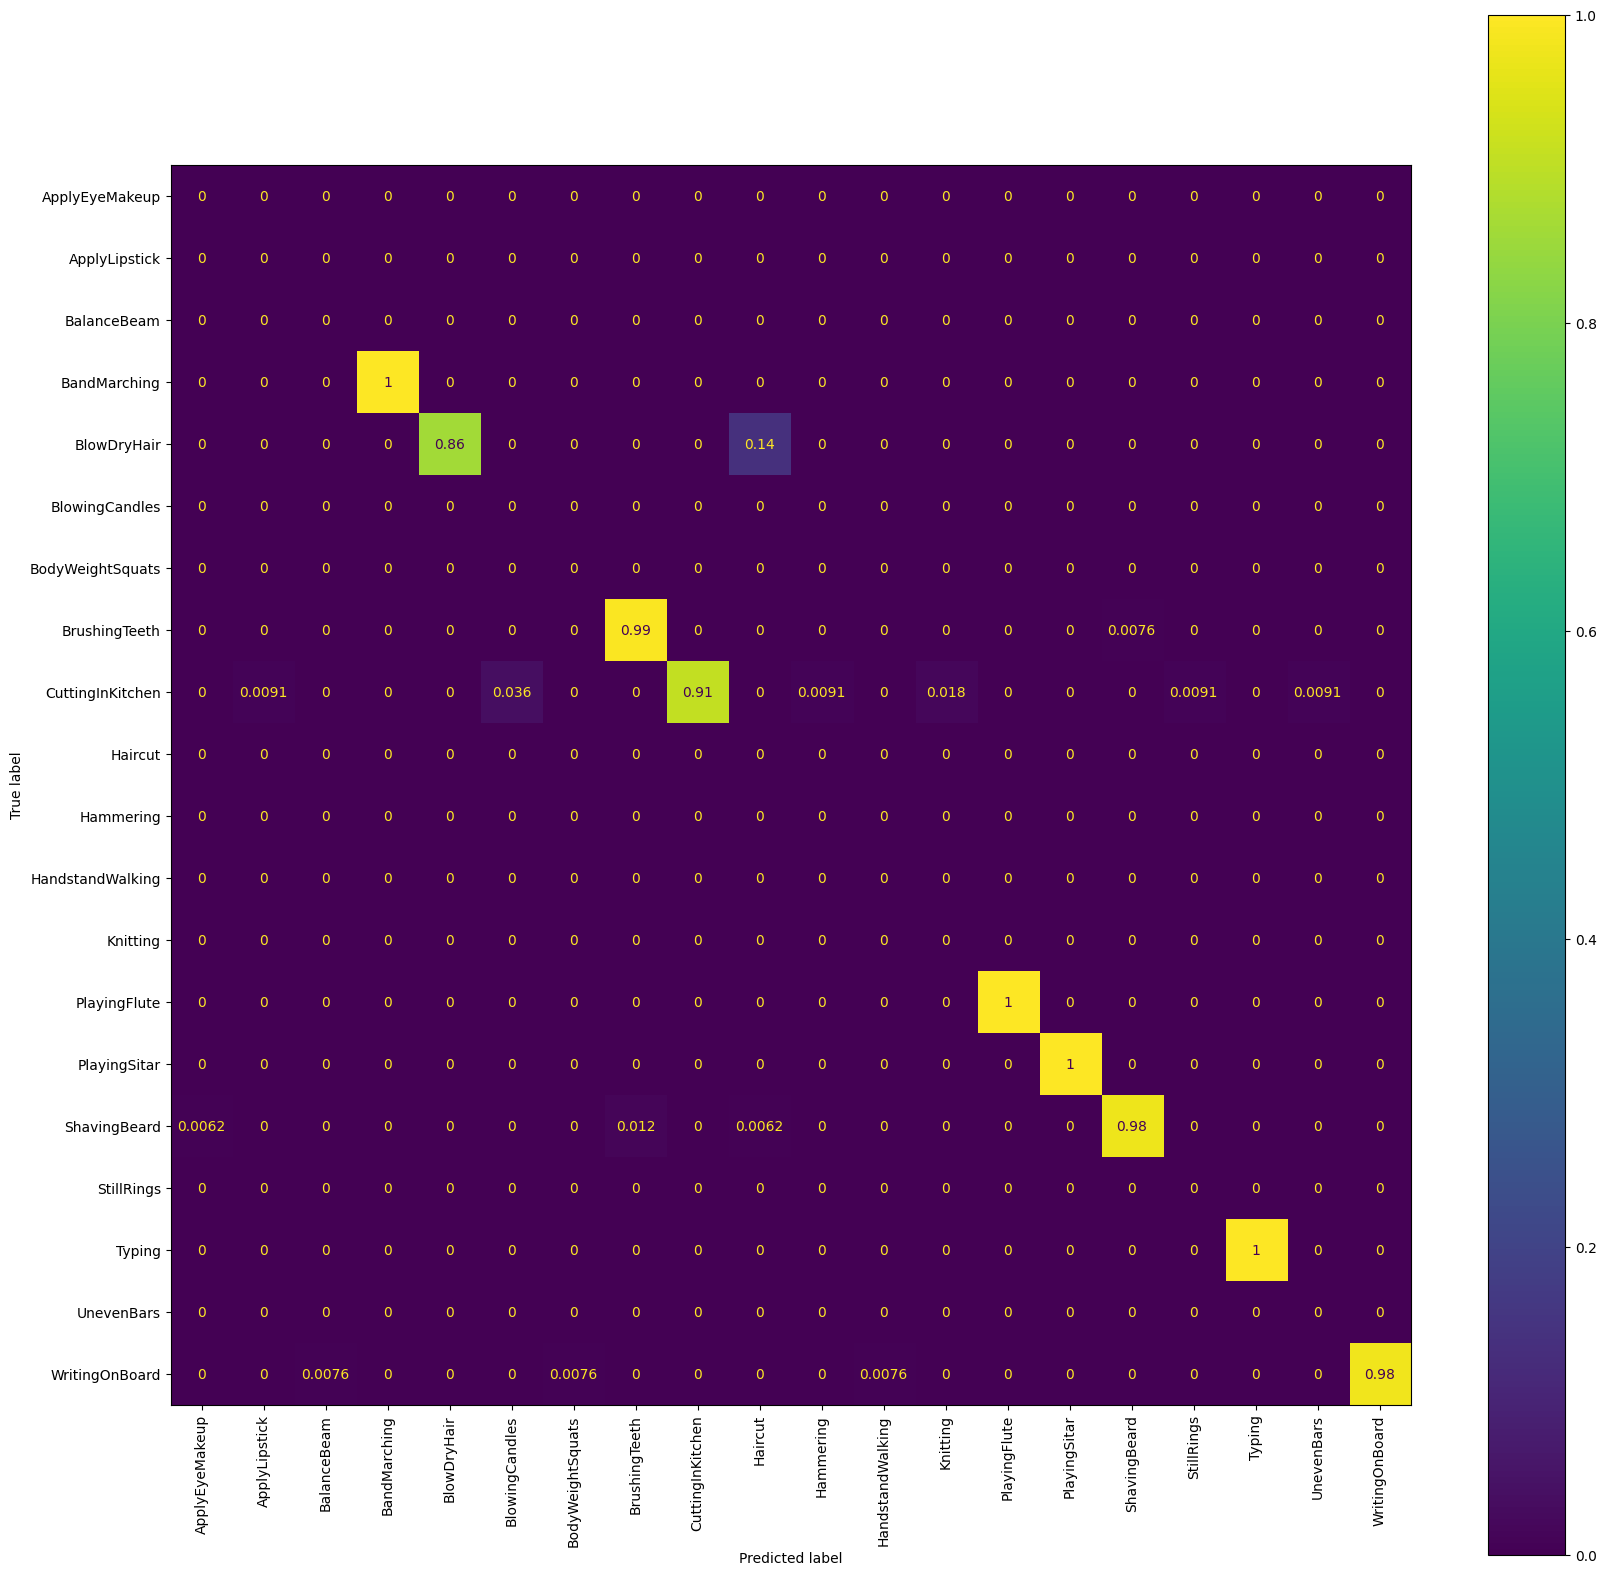

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay

# filtered labels that does not have data
def plot_confusion_matrix(y_true, y_pred, labels, fsize=(15, 15)):
    # Find unique labels in y_true and y_pred
    unique_labels = np.unique(np.concatenate([y_true, y_pred]))
    
    # Filter labels and create a mapping from original label indices to new indices
    filtered_labels = [labels[i] for i in unique_labels]
    label_mapping = {label: i for i, label in enumerate(unique_labels)}
    
    # Map y_true and y_pred to new label indices
    mapped_y_true = np.vectorize(label_mapping.get)(y_true)
    mapped_y_pred = np.vectorize(label_mapping.get)(y_pred)
    
    # Plot confusion matrix with filtered labels
    fig, ax = plt.subplots(figsize=fsize)
    ConfusionMatrixDisplay.from_predictions(mapped_y_true, mapped_y_pred, ax=ax, labels=np.arange(len(filtered_labels)), display_labels=filtered_labels, xticks_rotation="vertical", normalize='true')
    plt.show()
    return

plot_confusion_matrix(total_labels, total_preds, class_names, fsize=(20, 20))

## Average Loss & Accuracy per Class

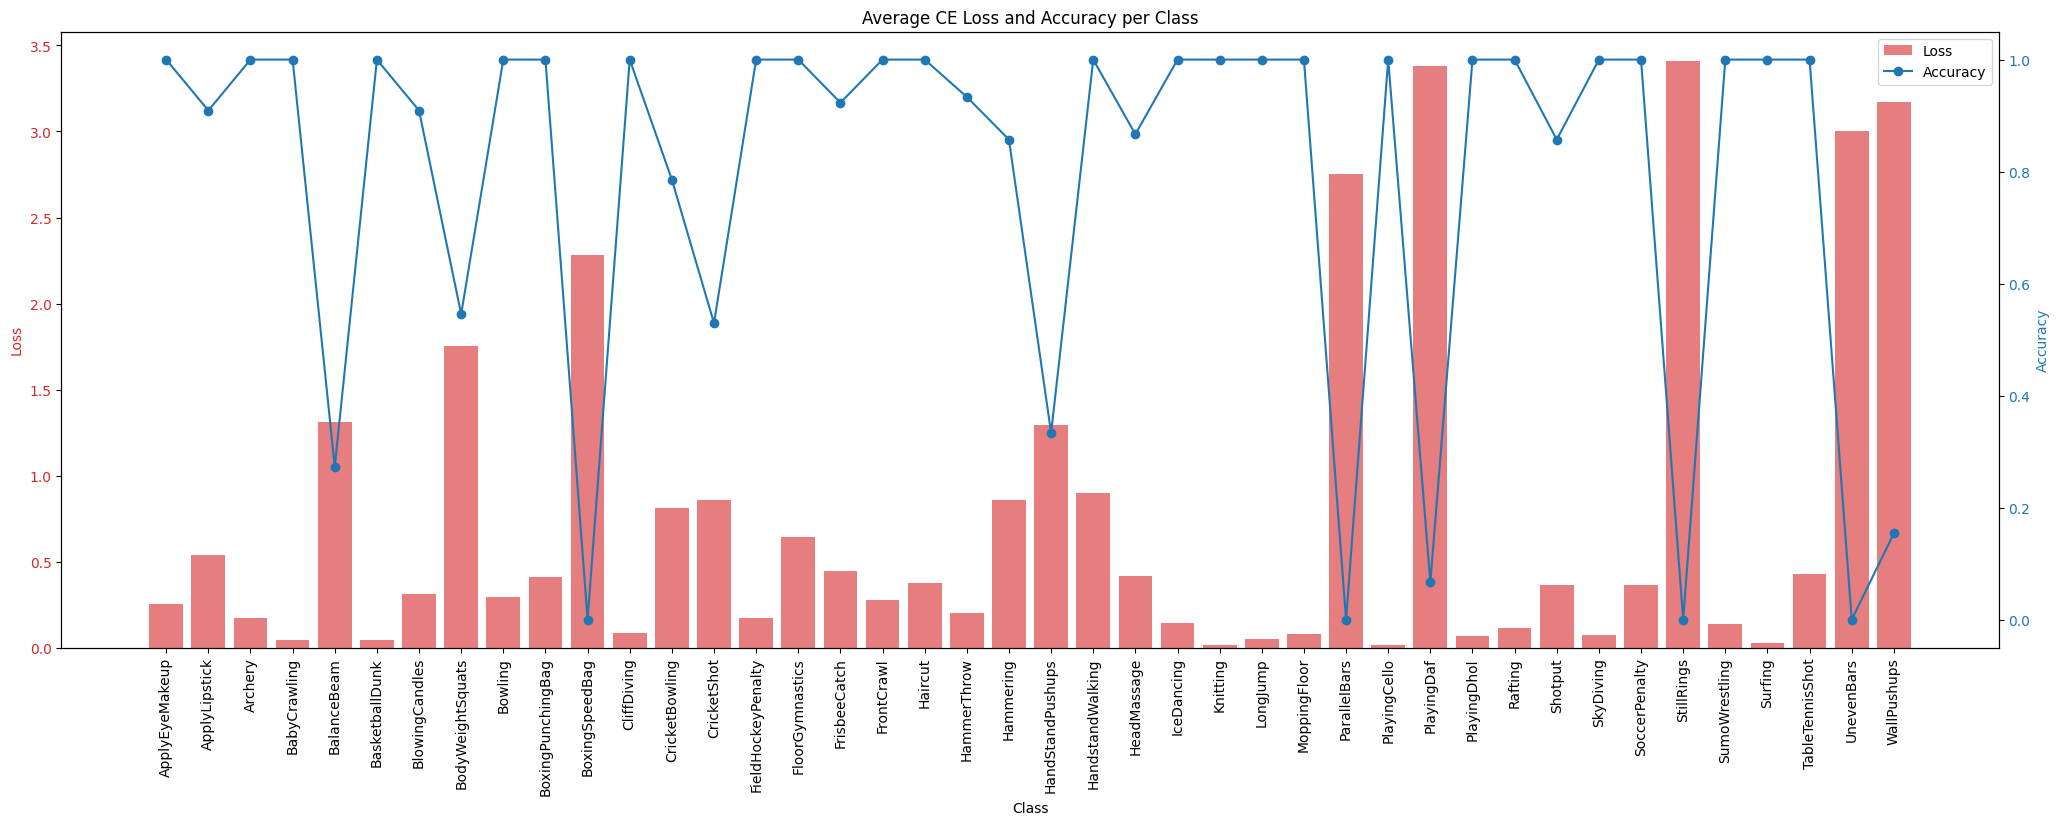

In [18]:
import collections

def loss_acc_per_class(total_losses, total_preds, total_labels, classes):
    # loss
    loss_per_class = {class_id: [] for class_id in range(len(classes))}
    for i, label in enumerate(total_labels):
        loss_per_class[label].append(total_losses[i])
    for k, v in loss_per_class.items():
        loss_per_class[k] = np.mean(np.asarray(v))
        # print(k, v)

    # Data
    x = [classes[i] for i in loss_per_class.keys()]
    yloss = list(loss_per_class.values())

    # accuracy
    acc_per_class = {class_id: [] for class_id in range(len(classes))}
    total_preds = total_preds.flatten()

    for i, label in enumerate(total_labels):
        if label == total_preds[i]: acc = 1
        else: acc = 0
        acc_per_class[label].append(acc)

    for k, v in acc_per_class.items():
        acc_per_class[k] = np.mean(np.asarray(v))
        # print(k, v)

    # Data
    x = [classes[i] for i in acc_per_class.keys()]
    yacc = list(acc_per_class.values())

    # Create figure and first axis
    fig, ax1 = plt.subplots(figsize=(25, 8))

    # exclude class with 0 data
    x = [x[i] for i in range(len(yloss)) if not np.isnan(yloss[i])]
    filt_yloss = [yloss[i] for i in range(len(yloss)) if not np.isnan(yloss[i])]
    yacc =  [yacc[i] for i in range(len(yloss)) if not np.isnan(yloss[i])]

    # Plot loss
    color = 'tab:red'
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Loss', color=color)
    ax1.bar(x, filt_yloss, color=color, alpha=0.6, label='Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', rotation=90)

    # Create second axis for accuracy
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(x, yacc, color=color, marker='o', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', rotation=90)

    # Title and legend
    plt.title('Average CE Loss and Accuracy per Class')
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

    # Show plot
    plt.show()
        
    return


loss_acc_per_class(total_losses, total_preds, total_labels, class_names)


## Cosine Similarity

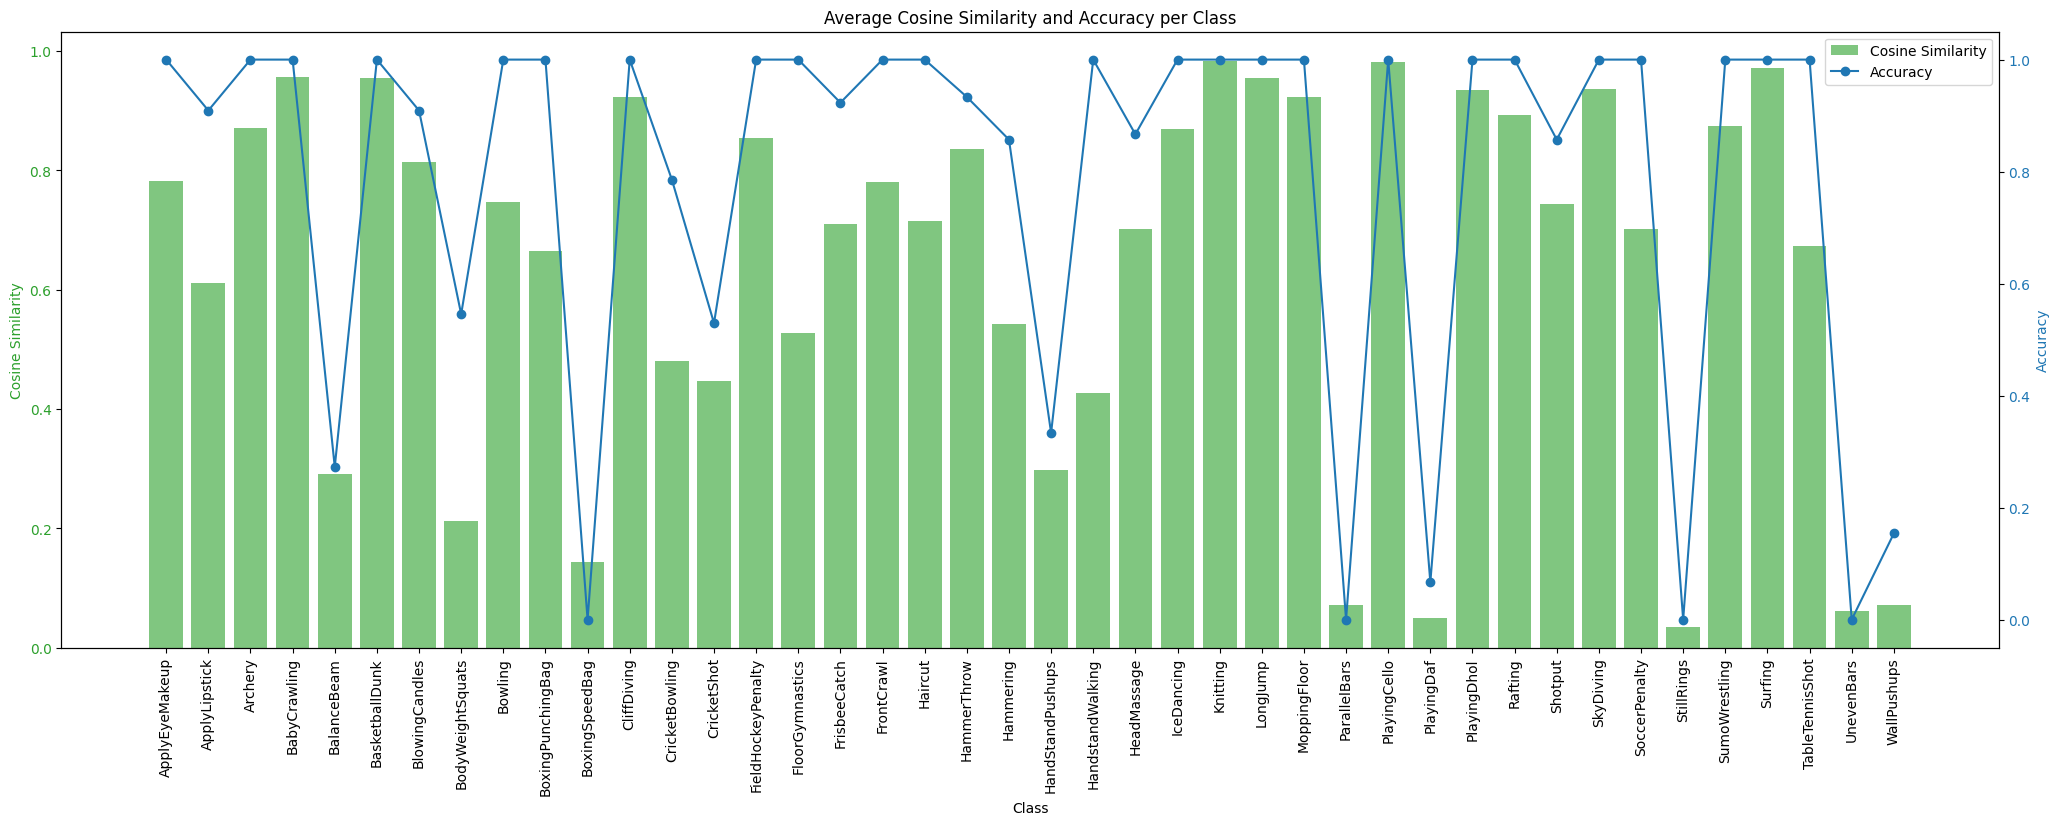

In [19]:
import collections

def sim_acc_per_class(total_similarities, total_preds, total_labels, classes):
    # Cosine Similarities
    sim_per_class = {class_id: [] for class_id in range(len(classes))}
    for i, label in enumerate(total_labels):
        sim_per_class[label].append(total_similarities[i])
    for k, v in sim_per_class.items():
        sim_per_class[k] = np.mean(np.asarray(v))
        # print(k, v)

    # Data
    x = [classes[i] for i in sim_per_class.keys()]
    ysim = list(sim_per_class.values())

    # accuracy
    acc_per_class = {class_id: [] for class_id in range(len(classes))}
    total_preds = total_preds.flatten()

    for i, label in enumerate(total_labels):
        if label == total_preds[i]: acc = 1
        else: acc = 0
        acc_per_class[label].append(acc)

    for k, v in acc_per_class.items():
        acc_per_class[k] = np.mean(np.asarray(v))
        # print(k, v)

    # Data
    x = [classes[i] for i in acc_per_class.keys()]
    yacc = list(acc_per_class.values())

    # Create figure and first axis
    fig, ax1 = plt.subplots(figsize=(25, 8))


    # exclude class with nan data
    x = [x[i] for i in range(len(ysim)) if not np.isnan(ysim[i])]
    filt_ysim = [ysim[i] for i in range(len(ysim)) if not np.isnan(ysim[i])]
    yacc =  [yacc[i] for i in range(len(ysim)) if not np.isnan(ysim[i])]


    # Plot Sim
    color = 'tab:green'
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Cosine Similarity', color=color)
    ax1.bar(x, filt_ysim, color=color, alpha=0.6, label='Cosine Similarity')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', rotation=90)

    # Create second axis for accuracy
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(x, yacc, color=color, marker='o', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', rotation=90)

    # Title and legend
    plt.title('Average Cosine Similarity and Accuracy per Class')
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

    # Show plot
    plt.show()
        

    return


sim_acc_per_class(total_similarities, total_preds, total_labels, class_names)


## Info NCE Loss

In [12]:
BATCH_SIZE = 12

from tqdm import tqdm
class Preprocessed_dataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.videos = []
        self.labels = []

        for i, dict_file in tqdm(enumerate(dataset), total=len(dataset)):
            video = pipeline(dict_file)['imgs'].unsqueeze(0).cuda().float()
            self.videos.append(video)
            label = dict_file['label']
            self.labels.append(label)
        
        self.videos = torch.cat(self.videos, dim=0)
        self.labels = torch.tensor(self.labels)
        print(self.videos.shape, self.labels.shape)
        assert len(self.videos) == len(self.labels)

    def __len__(self):
        return len(self.videos)
        
    def __getitem__(self, index):
        return self.videos[index], self.labels[index]


test_seen_loader = torch.utils.data.DataLoader(
    Preprocessed_dataset(test_seen_dataset), batch_size=BATCH_SIZE, shuffle=False
)

100%|██████████| 555/555 [00:18<00:00, 30.11it/s]


torch.Size([555, 32, 3, 224, 224]) torch.Size([555])


In [13]:
for video, label in test_seen_loader:
    print(video.shape, video.type())
    print(label.shape)
    break

torch.Size([12, 32, 3, 224, 224]) torch.cuda.FloatTensor
torch.Size([12])


In [15]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

def get_loss(model, loader, class_names):
    losses = {
        c: 0. for c in class_names
    }
    ttl_nums = {
        c: 0 for c in class_names
    }

    criterion = torch.nn.CrossEntropyLoss(reduction="none")

    for videos, labels in tqdm(loader, total=len(loader), leave=False):
        videos = videos
        # print(video.type())

        with torch.no_grad():
            with torch.cuda.amp.autocast():
                logits_per_video, logits_per_text, _, _ = model(videos)

        ground_truth = torch.arange(len(videos)).cuda()

        print('images', videos.shape)
        print('text_inputs', labels.shape)
        print('logits_per_image', logits_per_video.shape)
        print('logits_per_text', logits_per_text.shape)
        print('ground_truth', ground_truth.shape)
        
        with torch.no_grad():
            loss = (criterion(logits_per_video, ground_truth) + criterion(logits_per_text, ground_truth)) / 2

        unique_labels = torch.unique(labels)
        for c in unique_labels:
            mask = (labels == c).cuda()
            losses[class_names[c]] += loss[mask].sum().item()
            ttl_nums[class_names[c]] += mask.sum().item()
    
    for c in losses.keys():
        if ttl_nums[c] == 0:
            print(f"Warning: {c} has no samples in the test set")
            continue
        losses[c] /= ttl_nums[c]
    
    return losses


losses = get_loss(model, test_seen_loader, class_names)

text_features torch.Size([51, 512])
images torch.Size([12, 32, 3, 224, 224])
text_inputs torch.Size([12])
logits_per_image torch.Size([12, 51])
logits_per_text torch.Size([51, 12])
ground_truth torch.Size([12])


ValueError: Expected input batch_size (51) to match target batch_size (12).